In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.tsa.seasonal import STL
import numpy as np
import statsmodels.api as sm
from itertools import combinations

In [2]:
sns.set_style('whitegrid')
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(16, 6))

In [3]:
# data = pdr.get_data_fred('HOUSTNSA', '1959-01-01', '2019-06-01')
# housing = data.HOUSTNSA.pct_change().dropna()
data = pd.read_csv('daily_data.csv')
data.index = pd.to_datetime(data.date)
data['prexmas'] = data.index.week.isin([50,51]).astype(int)
data['xmas'] = data.index.week.isin([52,1]).astype(int)
data['dow'] = data.index.dayofweek
data['we'] = data.dow.isin([5,6]).astype(int)
data = data['2018-02-12':]
data = data.asfreq('d')
data.head(10)

,date,price,quantity,advertising,temp_av,score,comp_score,score_accum,comp_score_accum,score_ratio,views,customers,prexmas,xmas,dow,we
date,,,,,,,,,,,,,,,,
2018-02-12,2018-02-12,24.99,2.0,0.040417,2.944444,0.0,0.0,0.0,32.0,0.000000,NaN,NaN,0,0,0,0
2018-02-13,2018-02-13,24.99,2.0,0.040417,4.166667,4.0,0.0,4.0,32.0,0.125000,NaN,NaN,0,0,1,0
2018-02-14,2018-02-14,24.99,0.0,0.040417,3.333333,2.0,2.0,6.0,34.0,0.176471,NaN,NaN,0,0,2,0
2018-02-15,2018-02-15,24.99,0.0,0.040417,7.277778,2.0,-2.0,8.0,32.0,0.250000,NaN,NaN,0,0,3,0
2018-02-16,2018-02-16,24.99,1.0,0.040417,4.666667,2.0,0.0,10.0,32.0,0.312500,NaN,NaN,0,0,4,0
2018-02-17,2018-02-17,24.99,2.0,0.040417,5.666667,0.0,1.0,10.0,33.0,0.303030,NaN,NaN,0,0,5,1
2018-02-18,2018-02-18,24.99,0.0,0.040417,6.055556,0.0,-1.0,10.0,32.0,0.312500,NaN,NaN,0,0,6,1
2018-02-19,2018-02-19,24.99,0.0,1.874545,8.944444,1.0,0.0,11.0,32.0,0.343750,NaN,NaN,0,0,0,0
2018-02-20,2018-02-20,24.99,0.0,1.874545,8.444444,0.0,-2.0,11.0,30.0,0.366667,NaN,NaN,0,0,1,0


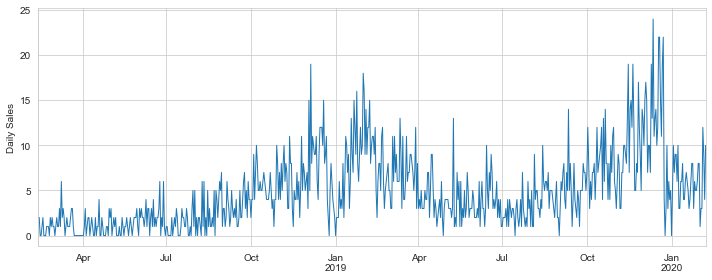

In [4]:
fig, ax = plt.subplots(1, figsize=(10,4))
data.quantity.plot(ax=ax, linewidth=1)
ax.set_ylabel('Daily Sales')
ax.set_xlabel(None)
plt.tight_layout()
fig.savefig('outputs/daily-sales.png')

In [5]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(data.quantity)

0.29321198850417407

In [6]:
'<<2 therefore significant evidence of possitive serial correlation.'

'<<2 therefore significant evidence of possitive serial correlation.'

In [7]:
from statsmodels.tsa.stattools import adfuller
adfuller(data.quantity)

(-3.237226075930715,
 0.017928507566565145,
 7,
 718,
 {'1%': -3.439490435810785,
  '5%': -2.8655738086413374,
  '10%': -2.568918067209286},
 3469.389680407644)

In [8]:
# <5% therefore we reject null hypothesis of unit root, (https://machinelearningmastery.com/time-series-data-stationary-python/)
# so can assume stationary but nor overwhelmingly convincingly, this is not a random walk.
# https://stats.stackexchange.com/questions/30569/what-is-the-difference-between-a-stationary-test-and-a-unit-root-test

In [9]:
adfuller(data.quantity.diff()[1:]) # <<<5% therefore we reject null hypothesis of unit root, 

(-8.10903003209899,
 1.2402003849457932e-12,
 20,
 704,
 {'1%': -3.4396728750301966,
  '5%': -2.8656541974330936,
  '10%': -2.5689608949670713},
 3470.2699006025987)

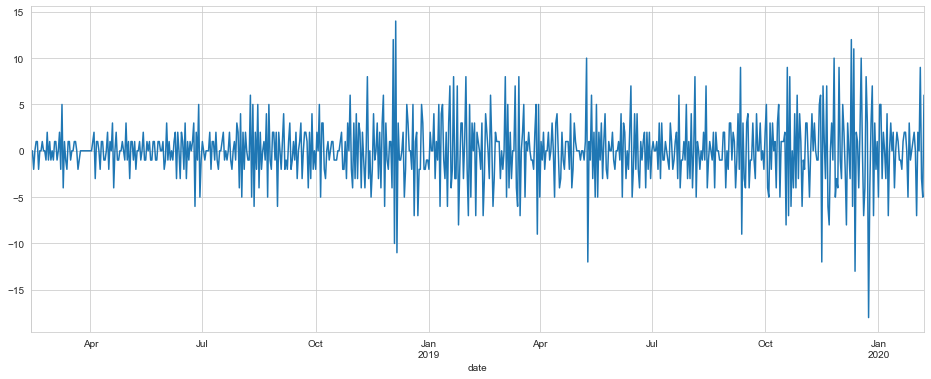

In [10]:
data.quantity.diff().plot()

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


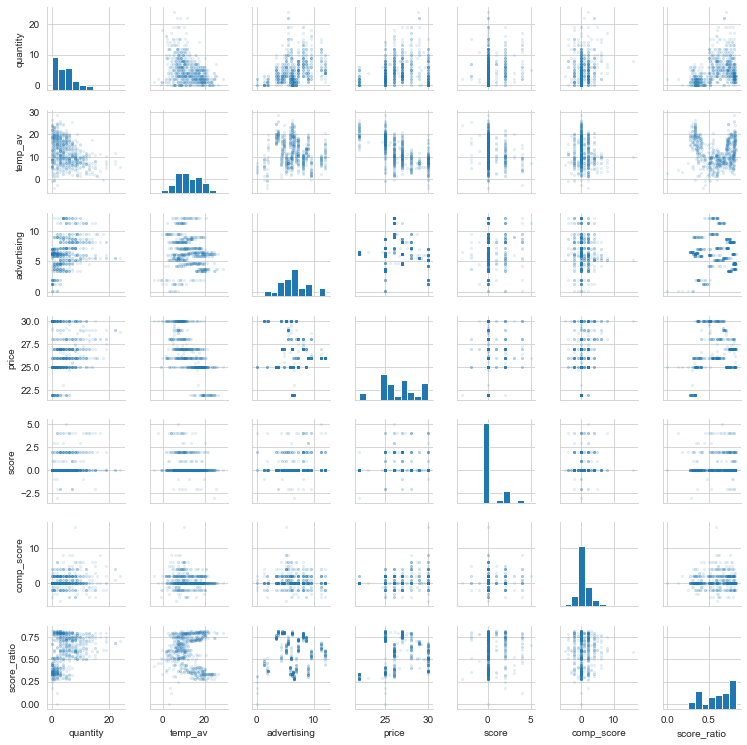

In [11]:
sns.pairplot(
    data[[
        'quantity',
        'temp_av',
        'advertising',
        'price',
        'score',
    #     'score_accum',
        'comp_score',
    #     'comp_score_accum',
        'score_ratio',
#         'we',
    #     'prexmas'
        ]],
    diag_kind = 'hist',
    plot_kws = {'alpha': .1, 's': 5, 'edgecolor': None},
    size = 1.5
)

dow
0    5.048077
1    5.076923
2    5.375000
3    5.028846
4    4.711538
5    4.291262
6    4.475728
Name: quantity, dtype: float64


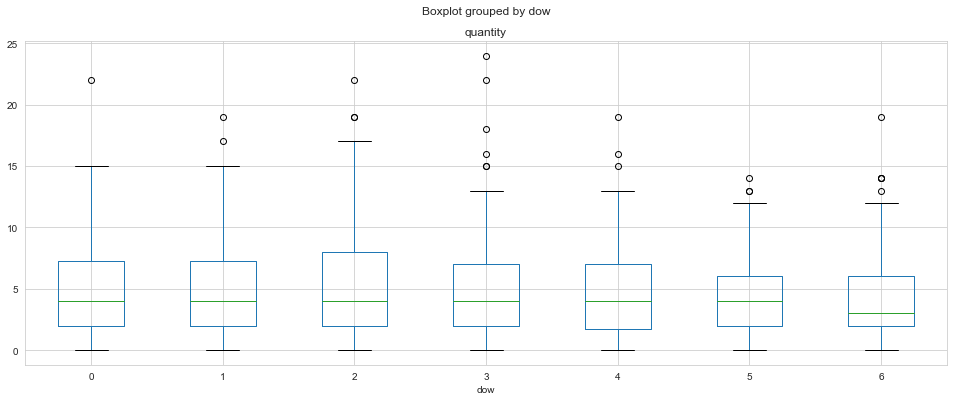

In [12]:
# looking for seasonality
# intra week
print(data.quantity.groupby(data.dow).mean())
data.boxplot(column='quantity', by='dow')

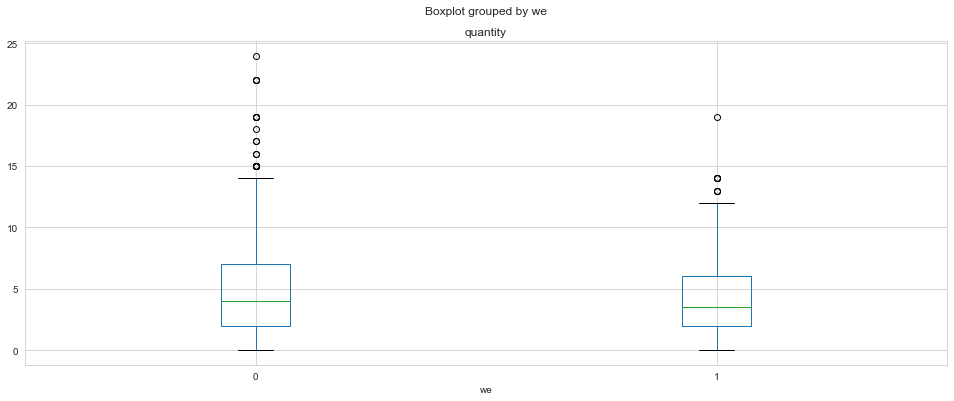

In [13]:
data.boxplot(column='quantity', by='we')

In [14]:
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.diagnostic import kstest_normal
x1 = data.quantity.loc[data.we == 1]
print(kstest_normal(x1, dist='norm', pvalmethod='table'))
x2 = data.quantity.loc[data.we == 0]
print(kstest_normal(x2, dist='norm', pvalmethod='table'))
# ttest_ind(x1, x2, alternative='two-sided', usevar='unequal', weights=(None, None), value=0)


(0.16368252750781975, 0.0009999999999998899)
(0.1333649214557457, 0.0009999999999998899)


In [15]:
# can t test because large samples
# p < 0,05 therefore rejevct that these distributions have the same mean
# https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.kstest_normal.html

In [16]:
# turns out these are exponential or maybe gaussian distributions
print(kstest_normal(x1, dist='exp', pvalmethod=None))
print(kstest_normal(x2, dist='exp', pvalmethod=None))

(0.14304801143225726, 0.0009999999999998899)
(0.12135225283702678, 0.0009999999999998899)


/usr/local/lib/python3.7/site-packages/statsmodels/stats/_lilliefors.py:272: FutureWarning: The default pvalmethod will change from "approx" to "table" after 0.11. The "table" method uses values from a very large simulation and is more accurate.  Explicitly set this parameter to "approx" or "table" to silence this warning
  warnings.warn(msg, FutureWarning)


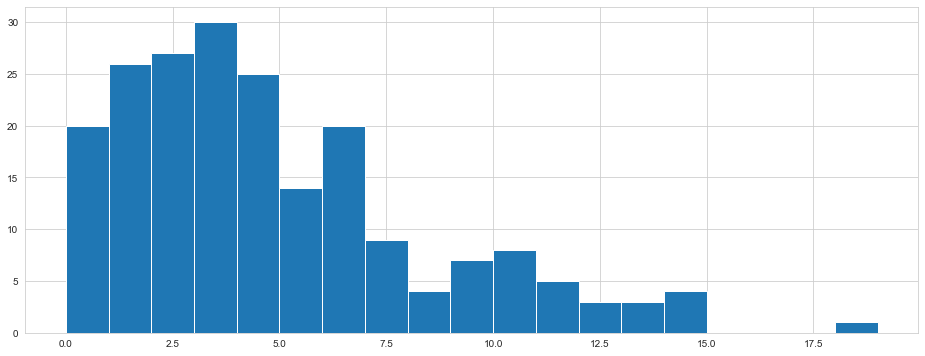

In [17]:
x1.hist(bins=19)

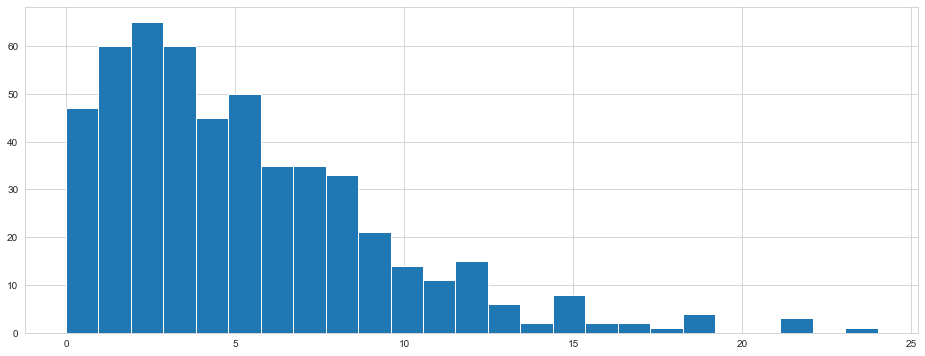

In [18]:
x2.hist(bins=25)

In [19]:
# intra year seasonality
# probably xmas

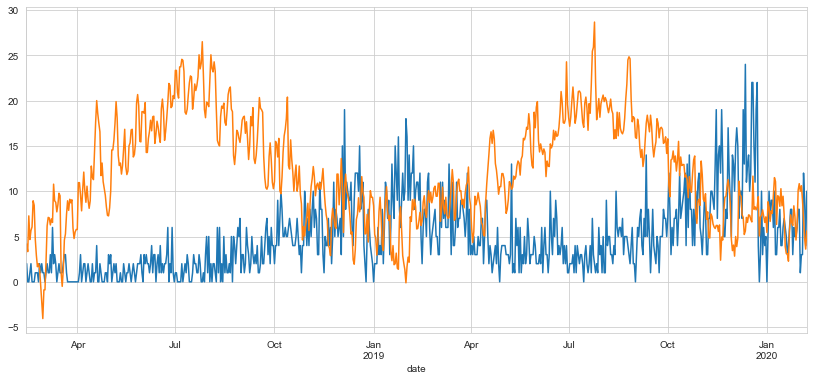

In [20]:
fig, ax = plt.subplots(1, figsize=(14,6))
data.quantity.plot(ax=ax)
data.temp_av.plot(ax=ax)

In [21]:
X = data[['temp_av', 'score_accum']]
X = sm.add_constant(X)
cointegration_model = sm.OLS(data.quantity, X)
result = cointegration_model.fit()
result.summary()

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               quantity   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     159.1
Date:                Wed, 06 May 2020   Prob (F-statistic):           5.48e-58
Time:                        22:58:42   Log-Likelihood:                -1918.5
No. Observations:                 726   AIC:                             3843.
Df Residuals:                     723   BIC:                             3857.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.2345      0.373     14.027      0.000       4.502       5.967
temp_av        -0.2302      0.022    -10.324      0.000      -0.274      -0.186
score_accum     0.0218      0.002     12.934      0.000       0.018       0.025
==============================================================================
Omnibus:                      113.330   Durbin-Watson:                   1.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.894
Skew:                           0.937   Prob(JB):                     1.18e-45
Kurtosis:                       4.824   Cond. No.                         399.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
residuals = data.quantity - result.predict()
adfuller(residuals)

(-3.813063868481822,
 0.002776447259835403,
 16,
 709,
 {'1%': -3.439606888036868,
  '5%': -2.865625121924057,
  '10%': -2.5689454046801052},
 3464.9340951171666)

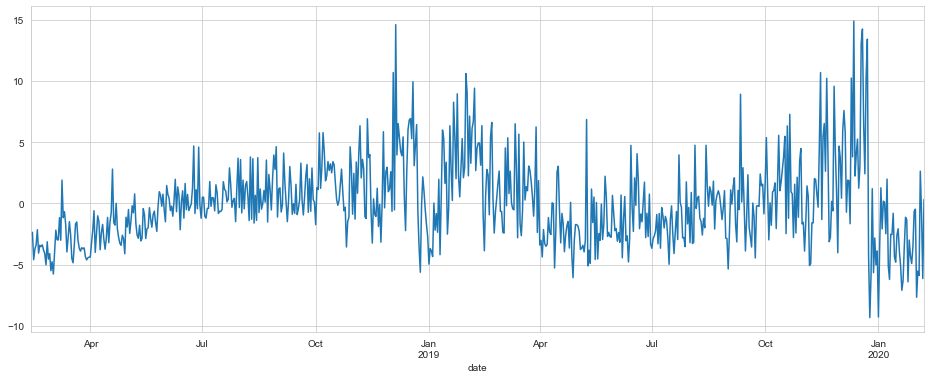

In [23]:
residuals.plot()


In [24]:
cointegrated = data.quantity - result.params['temp_av'] * data.temp_av - result.params['score_accum'] * data.score_accum

In [25]:
adfuller(cointegrated)

(-3.81306386848182,
 0.002776447259835423,
 16,
 709,
 {'1%': -3.439606888036868,
  '5%': -2.865625121924057,
  '10%': -2.5689454046801052},
 3464.934095117166)

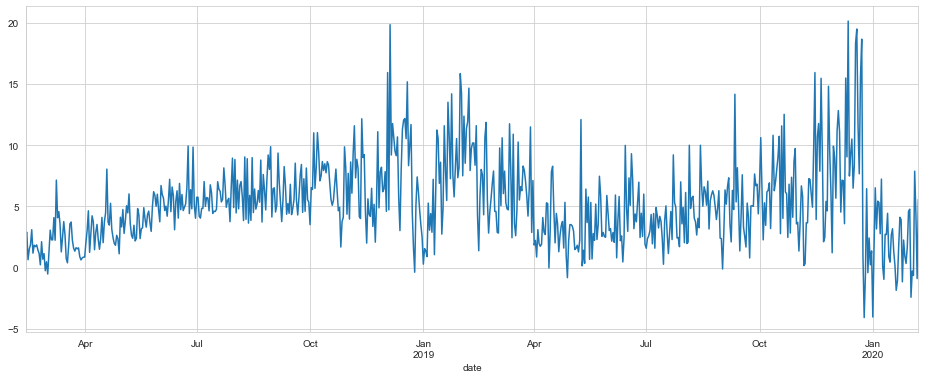

In [26]:
cointegrated.plot()

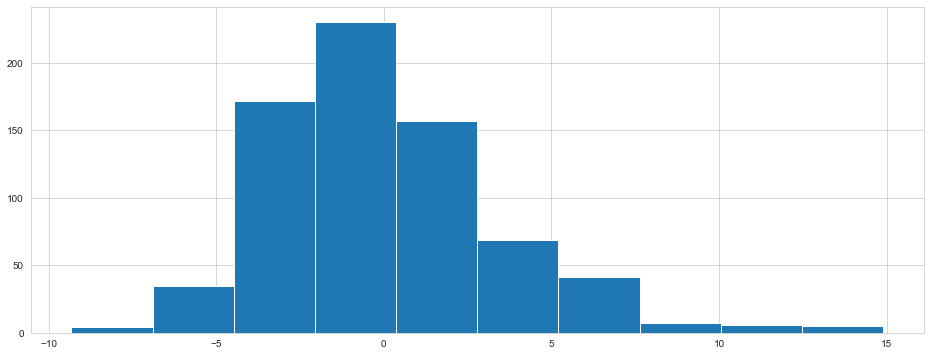

In [27]:
residuals.hist()

In [28]:
from statsmodels.stats.stattools import jarque_bera
list(zip(['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis'], jarque_bera(residuals, axis=0)))

[('Jarque-Bera', 206.89430557262042),
 ('Chi^2 two-tail prob.', 1.1843290342716068e-45),
 ('Skew', 0.9368631797983565),
 ('Kurtosis', 4.824453536077815)]

In [29]:
def ols_combinations_helper(data, combination):
    y = data.quantity
    x = data[list(combination)]
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    return model.fit()

In [30]:
options = [
    'temp_av',
    'advertising',
    'price',
    'score',
    'score_accum',
    'comp_score',
    'comp_score_accum',
    'score_ratio',
    'we',
    'prexmas'
]
results = {}
for i in range(1, 7):
    for combination in combinations(options, i):
        results[combination] = ols_combinations_helper(data, combination).aic
        

In [31]:
ranked_combinations = sorted(results, key=results.get)

In [32]:
ranked_combinations[0]

('temp_av', 'advertising', 'price', 'score_accum', 'we', 'prexmas')

In [33]:
for combination in ranked_combinations:
    print(combination, results[combination])

('temp_av', 'advertising', 'price', 'score_accum', 'we', 'prexmas') 3603.3255959713706
('temp_av', 'advertising', 'price', 'score_accum', 'comp_score_accum', 'prexmas') 3607.5044411921763
('temp_av', 'advertising', 'price', 'score_accum', 'score_ratio', 'prexmas') 3607.7654586064054
('temp_av', 'advertising', 'price', 'score_accum', 'prexmas') 3607.9791065826225
('temp_av', 'advertising', 'price', 'score_accum', 'comp_score', 'prexmas') 3608.974376580939
('temp_av', 'advertising', 'price', 'score', 'score_accum', 'prexmas') 3609.0207532799986
('temp_av', 'advertising', 'price', 'comp_score_accum', 'score_ratio', 'prexmas') 3610.5291658900137
('temp_av', 'advertising', 'score_accum', 'comp_score_accum', 'we', 'prexmas') 3619.235958146185
('temp_av', 'advertising', 'score_accum', 'we', 'prexmas') 3621.3545963854394
('temp_av', 'advertising', 'score_accum', 'score_ratio', 'we', 'prexmas') 3621.6850058429927
('temp_av', 'advertising', 'score', 'score_accum', 'we', 'prexmas') 3622.142189087

In [34]:
best_result = ols_combinations_helper(data, ranked_combinations[0])
best_result.summary()  # durbin watson starting to suggest no serial correlation...

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               quantity   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     122.9
Date:                Wed, 06 May 2020   Prob (F-statistic):          1.01e-106
Time:                        22:58:47   Log-Likelihood:                -1794.7
No. Observations:                 726   AIC:                             3603.
Df Residuals:                     719   BIC:                             3635.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.4331      2.208      4.725      0.000       6.098      14.768
temp_av        -0.2333      0.026     -9.099      0.000      -0.284      -0.183
advertising     0.4812      0.046     10.534      0.000       0.392       0.571
price          -0.3181      0.071     -4.485      0.000      -0.457      -0.179
score_accum     0.0225      0.001     15.478      0.000       0.020       0.025
we             -0.6103      0.237     -2.573      0.010      -1.076      -0.145
prexmas         6.7502      0.576     11.728      0.000       5.620       7.880
==============================================================================
Omnibus:                      137.185   Durbin-Watson:                   1.492
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              343.631
Skew:                           0.980   Prob(JB):                     2.41e-75
Kurtosis:                       5.742   Cond. No.                     2.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
variables = ['temp_av', 'advertising', 'price', 'score_accum', 'we', 'prexmas']

In [36]:
print(best_result.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &     quantity     & \textbf{  R-squared:         } &     0.506   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.502   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     122.9   \\
\textbf{Date:}             & Wed, 06 May 2020 & \textbf{  Prob (F-statistic):} & 1.01e-106   \\
\textbf{Time:}             &     22:58:47     & \textbf{  Log-Likelihood:    } &   -1794.7   \\
\textbf{No. Observations:} &         726      & \textbf{  AIC:               } &     3603.   \\
\textbf{Df Residuals:}     &         719      & \textbf{  BIC:               } &     3635.   \\
\textbf{Df Model:}         &           6      & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                      & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\mi

In [37]:
residuals = data.quantity - best_result.predict()
adfuller(residuals) # <<<5% therefor stationary

(-9.478045920278678,
 3.940707128107293e-16,
 3,
 722,
 {'1%': -3.439439614524914,
  '5%': -2.865551414233055,
  '10%': -2.5689061365397747},
 3436.5702483879586)

In [38]:
durbin_watson(residuals)

1.4924134132313254

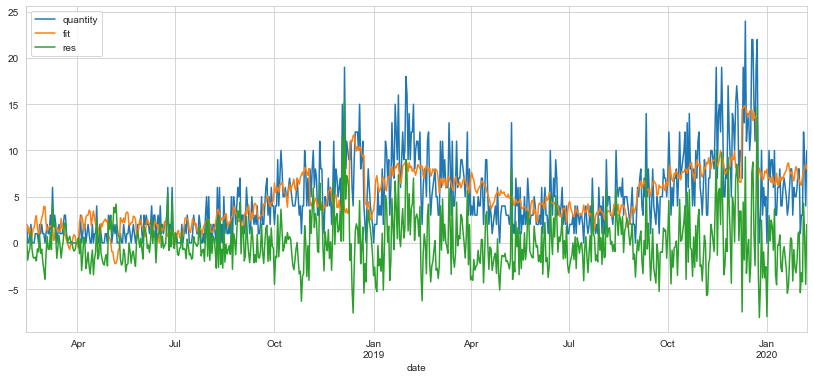

In [39]:
fig, ax = plt.subplots(1, figsize=(14,6))
plot_results = data.loc[:, ['quantity']]
plot_results['fit'] = best_result.predict()
plot_results['res'] = residuals
plot_results.plot(ax=ax)

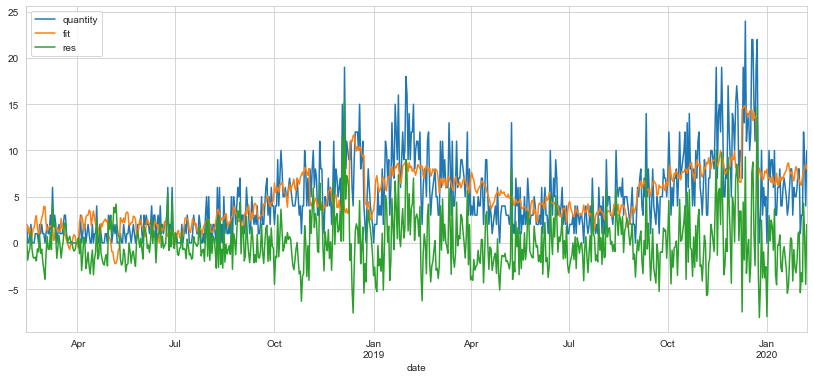

In [40]:
fig, ax = plt.subplots(1, figsize=(14,6))
plot_results = data.loc[:, ['quantity']]
plot_results['fit'] = best_result.predict()
plot_results['res'] = residuals
plot_results.plot(ax=ax)

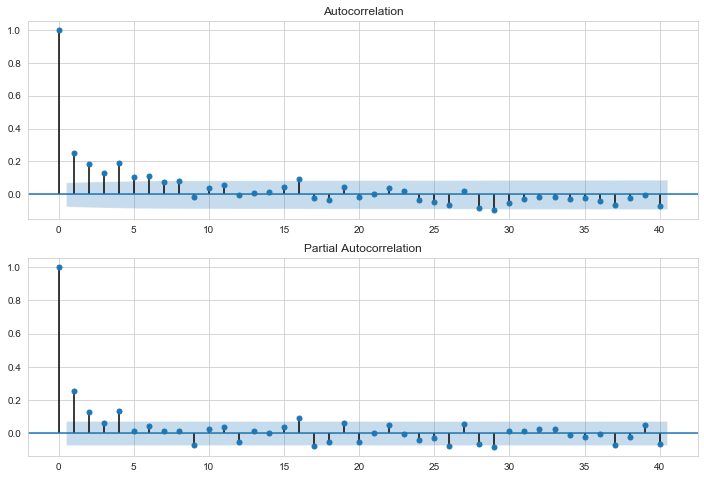

In [41]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)
# https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8
# https://www.ritchievink.com/blog/2018/09/26/algorithm-breakdown-ar-ma-and-arima-models/
# both the acf and pacf look to tail off suggesting AR and MA

In [42]:
from statsmodels.tsa.arima.model import ARIMA

In [43]:
variables = ['temp_av', 'advertising', 'score_accum', 'we', 'prexmas']

In [44]:
list(ranked_combinations[0])


['temp_av', 'advertising', 'price', 'score_accum', 'we', 'prexmas']

In [45]:
combination = ['temp_av', 'advertising', 'price', 'comp_score', 'score_ratio', 'prexmas'] ## price p > .109 so remove

In [82]:
arima = ARIMA(
    data.quantity,
    order=(1,0,1),
    exog=data[variables]
)
arma_results = arima.fit()
arma_results.summary()

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               quantity   No. Observations:                  726
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1754.448
Date:                Sat, 09 May 2020   AIC                           3526.895
Time:                        22:05:03   BIC                           3568.183
Sample:                    02-12-2018   HQIC                          3542.828
                         - 02-07-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9170      1.431      0.641      0.522      -1.887       3.721
temp_av        -0.0798      0.042     -1.906      0.057      -0.162       0.002
advertising     0.2602      0.123      2.115      0.034       0.019       0.501
score_accum     0.0265      0.005      4.901      0.000       0.016       0.037
we             -0.6108      0.243     -2.510      0.012      -1.088      -0.134
prexmas         5.7847      0.406     14.259      0.000       4.990       6.580
ar.L1           0.9461      0.018     53.098      0.000       0.911       0.981
ma.L1          -0.7803      0.033    -23.745      0.000      -0.845      -0.716
sigma2          7.2754      0.277     26.308      0.000       6.733       7.817
===================================================================================
Ljung-Box (Q):                       51.33   Jarque-Bera (JB):               230.63
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               4.45   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
print(arma_results.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &     quantity     & \textbf{  No. Observations:  } &    726      \\
\textbf{Model:}                  &  ARIMA(1, 0, 1)  & \textbf{  Log Likelihood     } & -1754.448   \\
\textbf{Date:}                   & Sat, 09 May 2020 & \textbf{  AIC                } &  3526.895   \\
\textbf{Time:}                   &     22:05:07     & \textbf{  BIC                } &  3568.183   \\
\textbf{Sample:}                 &    02-12-2018    & \textbf{  HQIC               } &  3542.828   \\
\textbf{}                        &   - 02-07-2020   & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                      & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}        &       0.9170  &        1.431     &     0.641  &         0.522        &       -1.887    &        3.721     \\
\textbf{temp\_av}

In [84]:
residuals = data.quantity - arma_results.predict()
print(durbin_watson)
adfuller(residuals) # <<<5% therefor positive serial correlation SAME AS TEST ABOVE 


<function durbin_watson at 0x122c005f0>


(-25.91246983234229,
 0.0,
 0,
 725,
 {'1%': -3.4394018678958544,
  '5%': -2.865534780932388,
  '10%': -2.5688972751486325},
 3427.9204359098057)

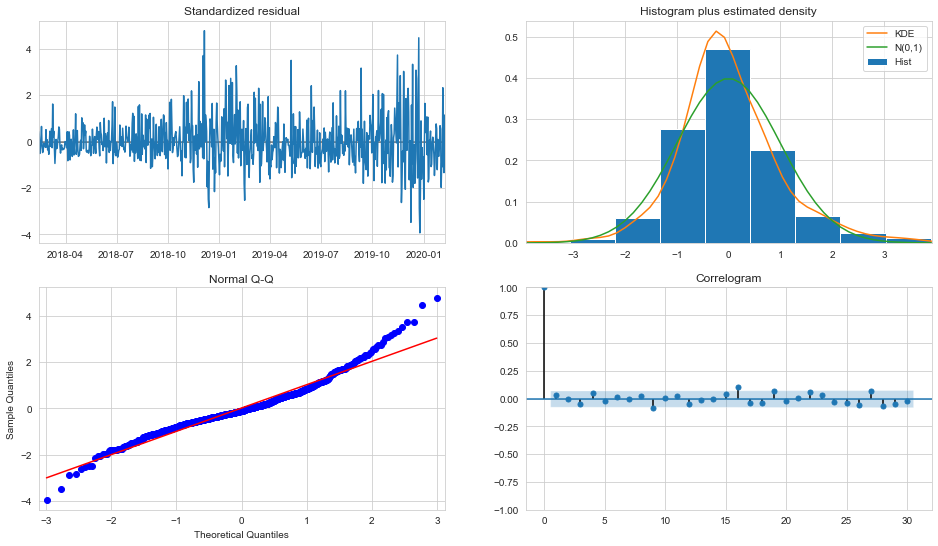

In [85]:
fig = plt.figure(figsize=(16,9))
fig = arma_results.plot_diagnostics(fig=fig, lags=30)

In [86]:
fig.savefig('outputs/diagnostics.png')

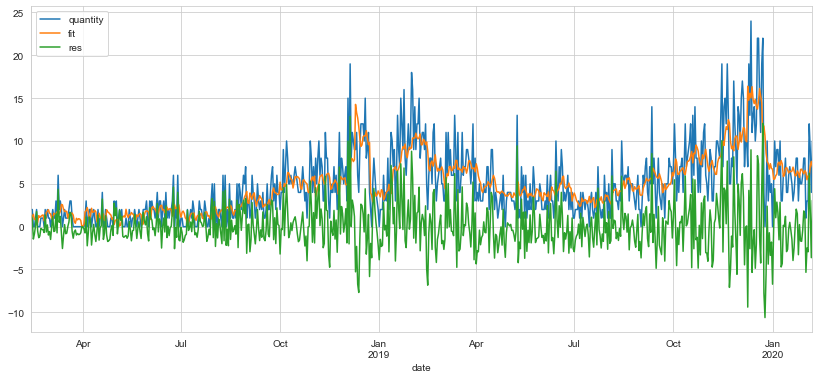

In [87]:
fig, ax = plt.subplots(1, figsize=(14,6))
plot_results = data.loc[:, ['quantity']]
plot_results['fit'] = arma_results.predict()
plot_results['res'] = residuals
plot_results.plot(ax=ax)

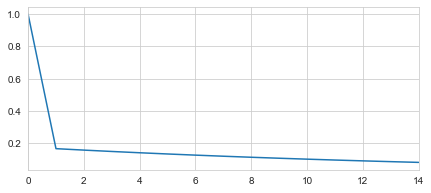

In [88]:
fig, ax = plt.subplots(1, figsize=(7,3))
arma_results.impulse_responses(steps=14).plot(ax=ax)

In [89]:
fig.savefig('outputs/ARIMA101_impulse_response.png')

Text(0, 0.5, 'Residuals')

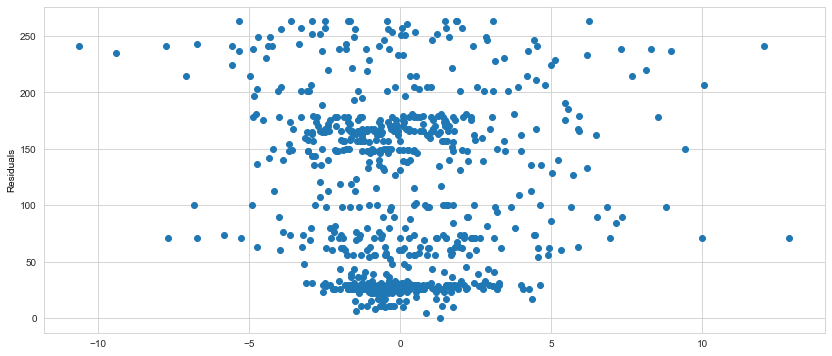

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.scatter(residuals, data.score_accum)
ax.set_ylabel('Fitted Sales', color='black')
ax.set_ylabel('Residuals', color='black')

In [ ]:
fig.savefig('outputs/residvsfitted.png')

In [96]:
durbin_watson(residuals)

1.9250945405546998

In [53]:
arima = ARIMA(
    data.quantity,
    order=(3,0,3),
    exog=data[variables]
)
arma_results = arima.fit()
arma_results.summary()

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               quantity   No. Observations:                  726
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1752.329
Date:                Wed, 06 May 2020   AIC                           3530.659
Time:                        22:58:55   BIC                           3590.297
Sample:                    02-12-2018   HQIC                          3553.674
                         - 02-07-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8958      1.839      0.487      0.626      -2.710       4.501
temp_av        -0.0738      0.044     -1.665      0.096      -0.161       0.013
advertising     0.2213      0.130      1.709      0.087      -0.033       0.475
score_accum     0.0264      0.008      3.365      0.001       0.011       0.042
we             -0.5670      0.250     -2.264      0.024      -1.058      -0.076
prexmas         5.9673      0.397     15.040      0.000       5.190       6.745
ar.L1          -0.1751      0.279     -0.629      0.530      -0.721       0.371
ar.L2           0.7350      0.112      6.545      0.000       0.515       0.955
ar.L3           0.3663      0.263      1.390      0.164      -0.150       0.883
ma.L1           0.3883      0.272      1.429      0.153      -0.144       0.921
ma.L2          -0.5408      0.117     -4.616      0.000      -0.770      -0.311
ma.L3          -0.3940      0.206     -1.914      0.056      -0.797       0.009
sigma2          7.3103      0.282     25.931      0.000       6.758       7.863
===================================================================================
Ljung-Box (Q):                       48.89   Jarque-Bera (JB):               228.38
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               4.50   Skew:                             0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
print(arma_results.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &     quantity     & \textbf{  No. Observations:  } &    726      \\
\textbf{Model:}                  &  ARIMA(3, 0, 3)  & \textbf{  Log Likelihood     } & -1752.329   \\
\textbf{Date:}                   & Wed, 06 May 2020 & \textbf{  AIC                } &  3530.659   \\
\textbf{Time:}                   &     22:58:55     & \textbf{  BIC                } &  3590.297   \\
\textbf{Sample:}                 &    02-12-2018    & \textbf{  HQIC               } &  3553.674   \\
\textbf{}                        &   - 02-07-2020   & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                      & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}        &       0.8958  &        1.839     &     0.487  &         0.626        &       -2.710    &        4.501     \\
\textbf{temp\_av}

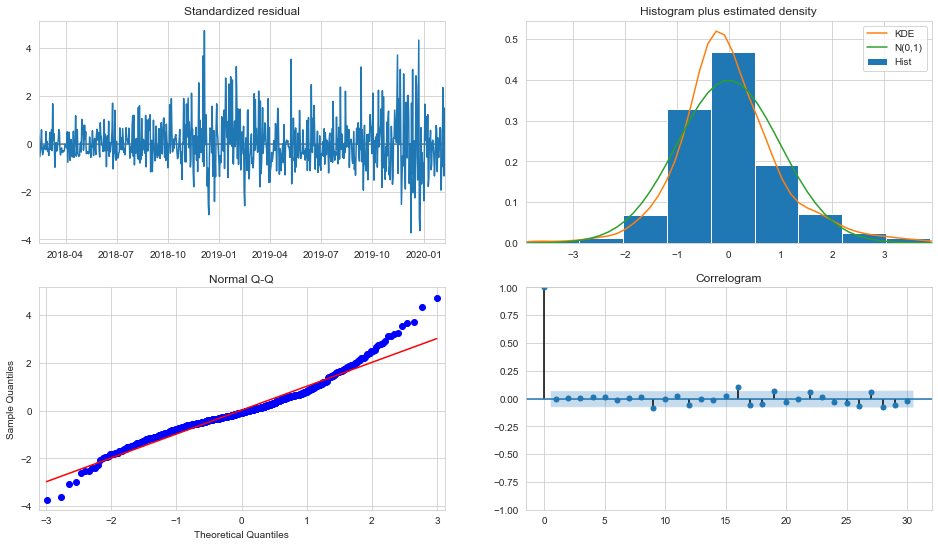

In [55]:
fig = plt.figure(figsize=(16,9))
fig = arma_results.plot_diagnostics(fig=fig, lags=30)

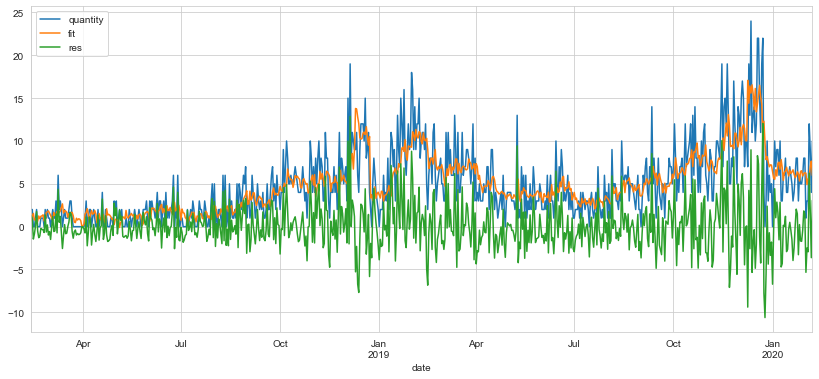

In [56]:
fig, ax = plt.subplots(1, figsize=(14,6))
plot_results = data.loc[:, ['quantity']]
plot_results['fit'] = arma_results.predict()
plot_results['res'] = residuals
plot_results.plot(ax=ax)

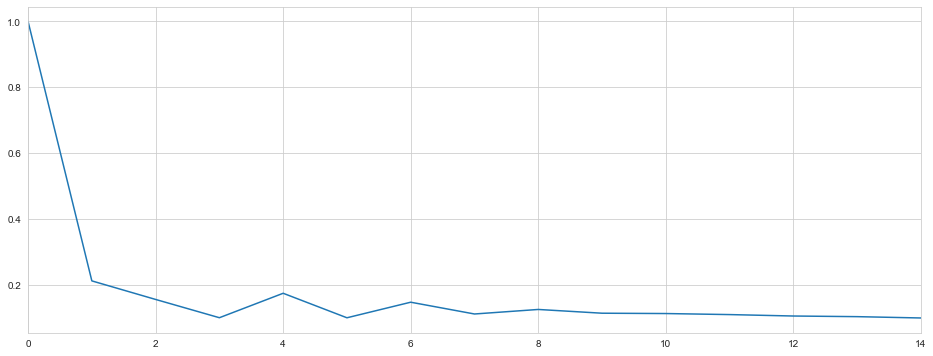

In [57]:
arma_results.impulse_responses(steps=14).plot()